<font color='blue'> **03 - Toth Problem** </font> 

In [1]:
import pathlib as pl ; import flopy ; import matplotlib.pyplot as plt ; import pandas as pd ; import numpy as np ; from flopy.plot.styles import styles  ; from pathlib import Path

_R = Path("_R")   ; _R.mkdir(exist_ok=True); TA = Path("_R/03_ex-gwf-toth"); TA.mkdir(exist_ok=True) ; sim_name = "J_Toth" ; parameter_units = {"recharge": "$ft/s$"}  

In [2]:
length_units = "feet" ; Lx = 20000   ; top = 10000  ;  nlay = 200   ; nrow = 1 ;  ncol = 100                               ;  nper = 1   ; tdis_ds = ((1.0, 1.0, 1),)
time_units = "days"   ; delr = 200   ; hk = 1  ; delz = top / nlay  ; botm = [top - (k + 1) * delz for k in range(nlay)]   ; ninner = 100

aa = 200.0  ; alpha = np.arctan2(1000, Lx) ;period=5000.0 ; bb = 2*np.pi/period        
def get_z(z0, aa, bb, alpha, xX):   return z0 + xX * np.tan(alpha) + aa * np.sin(bb * xX / np.cos(alpha)) / np.cos(alpha)
xX = np.arange(delr / 2, Lx + delr / 2, delr)       ; zZ = get_z(top, aa, bb, alpha, xX)      ; chdspd = [[0, 0, j, zZ[j]] for j in range(ncol)]     

np.savetxt(TA/"a_botn.csv", botm, delimiter = ",")  ; np.savetxt(TA/"b_z.csv"   , zZ, delimiter = ",") 
np.savetxt(TA/"c_x.csv", xX, delimiter = ",")       ; np.savetxt(TA/"d_chd.csv" , chdspd, delimiter = ",")  

In [3]:
sim = flopy.mf6.MFSimulation  (sim_name=sim_name, sim_ws=TA)                        ; tdis = flopy.mf6.ModflowTdis  (sim)
ims = flopy.mf6.ModflowIms    (sim, print_option="all", inner_maximum=ninner)       ; gwf = flopy.mf6.ModflowGwf    (sim, modelname=sim_name, save_flows=True)
dis = flopy.mf6.ModflowGwfdis (gwf, nlay=nlay, nrow=nrow, ncol=ncol, top=top, botm=botm, delr=delr)                 ; ic = flopy.mf6.ModflowGwfic   (gwf, strt=top)
npf = flopy.mf6.ModflowGwfnpf (gwf, save_specific_discharge=True, k=hk) ; chd = flopy.mf6.ModflowGwfchd (gwf, stress_period_data=chdspd)    ; SV = [("HEAD", "ALL"), ("BUDGET", "ALL")]
oc = flopy.mf6.ModflowGwfoc   (gwf,budget_filerecord=f"{sim_name}.bud",head_filerecord=f"{sim_name}.hds",printrecord=SV,saverecord=SV)
sim.write_simulation(silent=True)  ; sim.run_simulation(silent=True)

(True, [])

In [4]:
ml = sim.get_model(sim_name) ; print("OC package_Flow  : ", ml.oc.output.methods()) 
TA = sim.simulation_data.mfpath.get_sim_path()                  ; head = gwf.output.head().get_data()  ; bud = gwf.output.budget()        # head, bud
spdis = bud.get_data(text="DATA-SPDIS")[0]                      ; qx, qy, qz = flopy.utils.postprocessing.get_specific_discharge(spdis, gwf)  # spdis
u = qx.reshape((nlay, ncol)) ; phi = u[-1::-1].cumsum(axis=0)   ; phi = np.flipud(phi)                                             # gwf = sim.gwf[0]

OC package_Flow  :  ['list()', 'zonebudget()', 'budget()', 'budgetcsv()', 'head()']


In [5]:
qx2 = qx[:,0,:] ; sa1 = pd.DataFrame(qx2);  sa1.to_csv (TA / "e_qx2(2D).csv")  
sa2 = pd.DataFrame(phi);  sa2.to_csv (TA / "f_phi(2D).csv")    ; print('u',u.shape, 'qx',qx.shape, 'qx2 = u',qx2.shape, 'phi',phi.shape)

u (200, 100) qx (200, 1, 100) qx2 = u (200, 100) phi (200, 100)


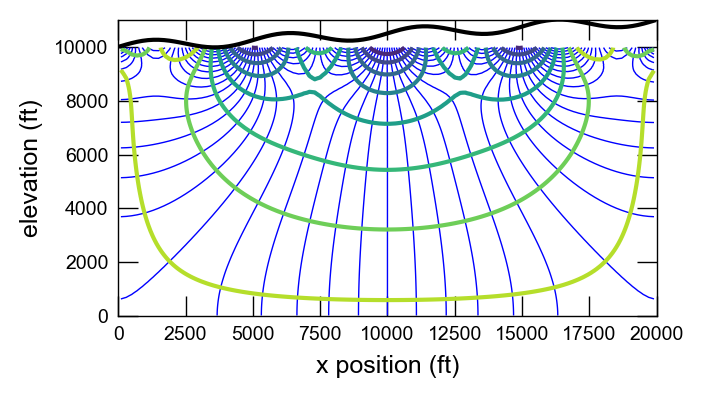

In [6]:
with styles.USGSMap():
    fig, ax = plt.subplots(1, 1, figsize=(16, 2), dpi=200, tight_layout=True)
    pxs = flopy.plot.PlotCrossSection(model=gwf, ax=ax, line={"row": 0})
    pxs.contour_array(head,levels=np.arange(top, zZ.max(), 25),linewidths=0.5,colors="b",linestyles="solid")
    pxs.contour_array(phi, levels=np.linspace(phi.min(), phi.max(), 10))
    
    ax.plot(xX,zZ,"k-") ; ax.set_xlabel("x position (ft)") ;ax.set_ylabel("elevation (ft)")    # synoidal
    ax.set_aspect(1.0) ;ax.set_xlim(0,20000) ; ax.set_ylim(0,11000)                          ; plt.show() ; fig.savefig(TA/'03_Toth')

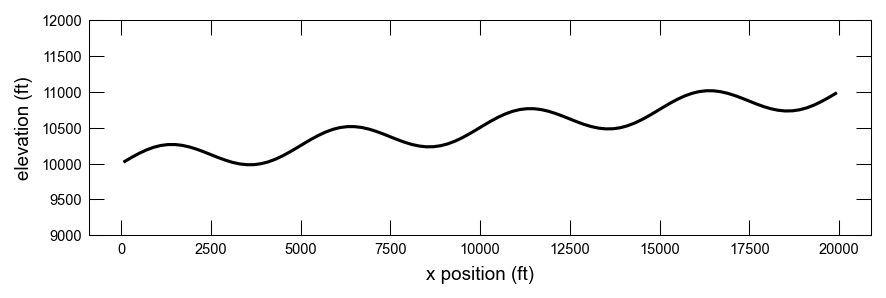

In [7]:
with styles.USGSMap():
    fig, ax = plt.subplots(1, 1, figsize=(12, 2), dpi=150, tight_layout=True)
    ax.plot(xX,zZ,"k-") ; ax.set_xlabel("x position (ft)") ;ax.set_ylabel("elevation (ft)") ; ax.set_aspect(2) ; ax.set_ylim(9000,12000)                          ; plt.show()